In [ ]:
! pip install tensorflowjs


## Import TensorFlow and other libraries

In [3]:
import os 
import matplotlib.pyplot as plt
import random
import numpy as np
from skimage import io
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt


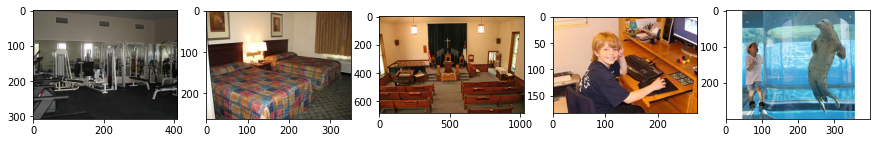

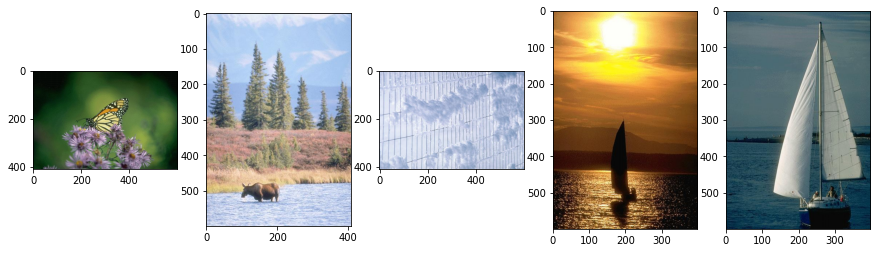

In [4]:
original_dir = "training"
img_folders = os.listdir(original_dir)
for i in img_folders:
  images_path = os.path.join(original_dir , i)
  fig , axs = plt.subplots(1, 5 , figsize = (15 ,10))
  for ax in axs:
    fname = os.listdir(images_path)
    ran = fname[random.randint(0 ,len(fname)-1)]
    pic = io.imread(os.path.join(images_path , ran))
    ax.imshow(pic)
plt.show()

### Splitting the data into train / validate

In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  original_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 800 files belonging to 2 classes.
Using 640 files for training.


In [6]:

val_ds = tf.keras.utils.image_dataset_from_directory(
  original_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 800 files belonging to 2 classes.
Using 160 files for validation.


In [7]:
# class names
class_names = train_ds.class_names
print(class_names)

['indoor', 'outdoor']


### Visualize the data after resizing

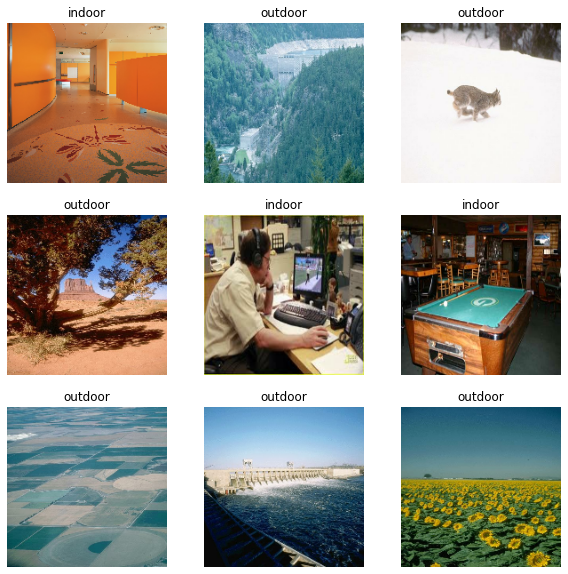

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#####  Caching data from disk to memory while training 

from tf documentataion

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Build a Sequential model
 

In [17]:
num_classes = len(class_names)

model = Sequential([
  # rescaling images to 0-1
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),# max pooling layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [18]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 45, 45, 64)       

In [30]:
# train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
20/20 [==============================] - 10s 501ms/step - loss: 0.7520 - accuracy: 0.5984 - val_loss: 0.6200 - val_accuracy: 0.6938
Epoch 2/10
20/20 [==============================] - 10s 502ms/step - loss: 0.5531 - accuracy: 0.7391 - val_loss: 0.5314 - val_accuracy: 0.7563
Epoch 3/10
20/20 [==============================] - 10s 475ms/step - loss: 0.4520 - accuracy: 0.7812 - val_loss: 0.4639 - val_accuracy: 0.7937
Epoch 4/10
20/20 [==============================] - 9s 434ms/step - loss: 0.3489 - accuracy: 0.8484 - val_loss: 0.3989 - val_accuracy: 0.8250
Epoch 5/10
20/20 [==============================] - 10s 485ms/step - loss: 0.2739 - accuracy: 0.8687 - val_loss: 0.4870 - val_accuracy: 0.7812
Epoch 6/10
20/20 [==============================] - 10s 499ms/step - loss: 0.2107 - accuracy: 0.9203 - val_loss: 0.3579 - val_accuracy: 0.8500
Epoch 7/10
20/20 [==============================] - 10s 493ms/step - loss: 0.1282 - accuracy: 0.9578 - val_loss: 0.4217 - val_accuracy: 0.8250


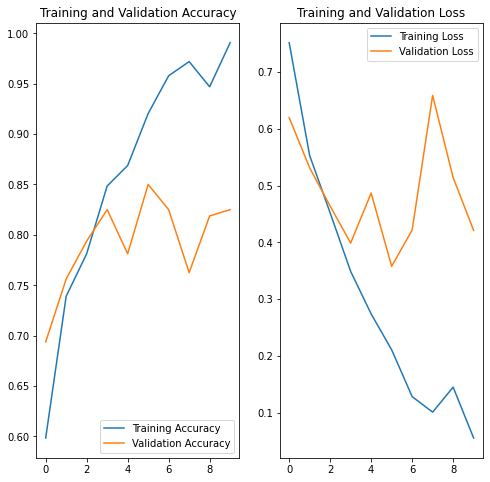

In [31]:
# plot the training accuracy and loss 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  Data Augmentation 

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### plot sample of an augmentated image

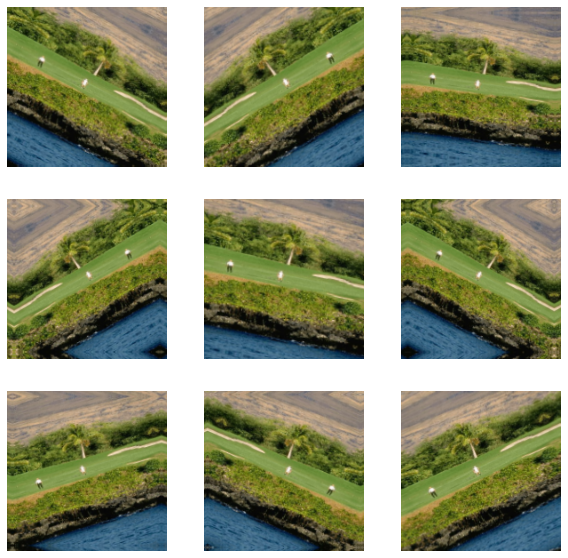

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
#build the model

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)),
  layers.Dropout(0.2),
  layers.MaxPool2D((2,2)),

  layers.Conv2D(64,(3,3),activation='relu'),
  layers.MaxPool2D(2,2),

  layers.Conv2D(128,(3,3), activation='relu'),
  layers.Dropout(0.3),
  layers.MaxPool2D(2,2),

  layers.Conv2D(128,(3,3), activation='relu'),
  layers.MaxPool2D(2,2),

  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])



In [21]:
# use callbacks to save the best model during training and early stopping to avoid overfitting 

callbacks = [ tf.keras.callbacks.ModelCheckpoint("SavedBestEpoch1" ,
                                             save_best_only = True,
                                             monitor = 'val_loss') ,
              tf.keras.callbacks.EarlyStopping(patience = 10,
                                           restore_best_weights = True)
             ]

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 dropout_3 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

In [25]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/100
20/20 [==============================] - 35s 2s/step - loss: 0.7056 - accuracy: 0.5844 - val_loss: 0.6518 - val_accuracy: 0.6250
Epoch 2/100
20/20 [==============================] - 32s 2s/step - loss: 0.5809 - accuracy: 0.6891 - val_loss: 0.5908 - val_accuracy: 0.7250
Epoch 3/100
20/20 [==============================] - 32s 2s/step - loss: 0.5209 - accuracy: 0.7328 - val_loss: 0.5667 - val_accuracy: 0.7188
Epoch 4/100
20/20 [==============================] - 30s 1s/step - loss: 0.4690 - accuracy: 0.7547 - val_loss: 0.6003 - val_accuracy: 0.6812
Epoch 5/100
20/20 [==============================] - 28s 1s/step - loss: 0.4633 - accuracy: 0.7906 - val_loss: 0.6188 - val_accuracy: 0.7188
Epoch 6/100
20/20 [==============================] - 31s 2s/step - loss: 0.4403 - accuracy: 0.8109 - val_loss: 0.4701 - val_accuracy: 0.8000
Epoch 7/100
20/20 [==============================] - 30s 1s/step - loss: 0.4438 - accuracy: 0.8016 - val_loss: 0.4881 - val_accuracy: 0.7437
Epoch 8/100
2

In [26]:
# ! tensorflowjs_converter --input_format=tf_saved_model  --output_format=tfjs_graph_model  --signature_name=serving_default --saved_model_tags=serve  "SavedBestEpoch"  "web_model"

! tensorflowjs_converter --input_format=tf_saved_model  --weight_shard_size_bytes=30000000  --output_format=tfjs_graph_model  --signature_name=serving_default --saved_model_tags=serve  "SavedBestEpoch"  "web_model2"


Writing weight file web_model2\model.json...


2022-05-16 21:27:58.233919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-16 21:27:58.234266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-16 21:28:02.074109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-05-16 21:28:02.074393: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-16 21:28:02.077863: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-H53QVSU
2022-05-16 21:28:02.078161: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-H53QVSU
2022-05-16 21:28:02.078570: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is

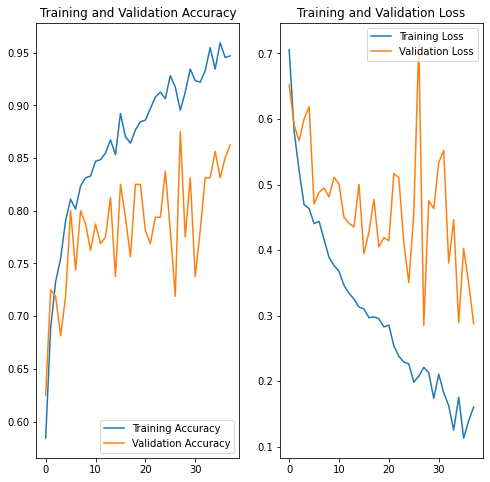

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[0.30917665 0.6908234 ]]
This image most likely belongs to outdoor with a 69.08 % confidence.


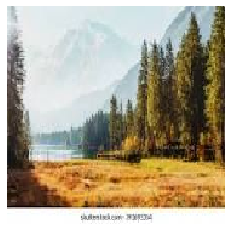

In [28]:
# make predictions for test data

img = tf.keras.utils.load_img("test image\download (7).jfif", target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
plot_color_image(img_array)

img_array = tf.expand_dims(img_array, 0) # Create a batch
test_model = tf.keras.models.load_model("SavedBestEpoch")
predictions = test_model.predict(img_array)
print(predictions)

print("This image most likely belongs to {} with a {:.2f} % confidence.".format(class_names[np.argmax(predictions[0])], 100 * np.max(predictions[0])))

In [29]:
print("This image most likely belongs to {} with a {:.2f} % confidence."
    .format(class_names[np.argmax(predictions[0])], 100 * np.max(predictions[0])))

This image most likely belongs to outdoor with a 69.08 % confidence.
